# Progressive GAN

In [498]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Resize, Lambda
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Data

In [499]:
def transform_in_size(size):
    return Compose([Resize((size, size)), ToTensor(), Lambda(lambda x: x * 2 - 1)])

def get_dataloader(size):
    dataset = CIFAR10('~/pytorch', train=True, download=True, transform=transform_in_size(size))
    return DataLoader(dataset, batch_size=32, drop_last=True, shuffle=False)

# CUDA

In [500]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
print(f"Learning on: {device}")

Learning on: cuda


# Generator
* TODO: Change UpsamplingBilinear to interpolate()
* TODO: Move to inner class

In [501]:
class GeneratorBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d()
        
    def forward(self, x):
        _, x = self.forward_with_img(x)
        
        return x
    
    def forward_with_img(self, x):
        img = self.upsample(x)
        x = F.leaky_relu(self.conv1(img))
        x = self.bn1(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.bn2(x)
        
        return img, x

In [502]:
class Generator(nn.Module):
    def __init__(self, channels=512):
        super().__init__()
        self.channels = channels
        self.trained_blocks = nn.ModuleList()
        self.new_block = self.create_initial_layer(channels)
        self.rgb = self.to_rgb(channels)
        
    def to_rgb(self, in_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, 3, 1, padding=0),
            nn.Tanh())
    
    def create_initial_layer(self, channels):
        module = nn.Sequential(
            nn.Conv2d(channels, channels, 4, padding=3),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(),
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU())
        
        return module
    
    def append_layer(self, channels):
        self.trained_blocks.append(self.new_block)
        self.new_block = GeneratorBlock(self.channels, channels)
        self.rgb = self.to_rgb(channels)
        self.channels = channels
        
    def forward(self, x, alpha=1.0):
        for block in self.trained_blocks:
            x = block(x)
            
        if alpha < 1.0:
            img , x = self.new_block.forward_with_img(x)
            img = self.rgb(img)
            x = self.rgb(x)
            
            x = img * (1 - alpha) + img * alpha
        else:
            x = self.new_block(x)
            x = self.rgb(x)
        
        return x

# Disciminator

In [503]:
class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.downsample = nn.AvgPool2d(2, 2)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = self.downsample(x)
        
        return x

In [504]:
class Discriminator(nn.Module):
    def __init__(self, channels=512):
        super().__init__()
        self.channels = channels
        self.trained_layers = nn.ModuleList()
        self.new_layer = self.create_initial_layer(channels)
        self.downsample = nn.AvgPool2d(2, 2)
        self.rgb = self.from_rgb(channels)
        
    def create_initial_layer(self, channels):
        module = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(channels, channels, 4, padding=0),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(channels, 1))
        
        return module
    
    def prepend_layer(self, channels):
        self.trained_layers.insert(0, self.new_layer)
        self.new_layer = DiscriminatorBlock(channels, self.channels)
        self.rgb = self.from_rgb(channels)
        self.channels = channels
        
    def from_rgb(self, channels):
        return nn.Conv2d(3, channels, 1, padding=0)
        
    def forward(self, x, alpha=1.0):
        if alpha < 1.0:
            skip = self.downsample(x)
            skip = self.rgb(skip)

            x = self.rgb(x)
            x = self.new_layer(x)
            x = skip * (1-alpha) + x * alpha
        else:
            x = self.rgb(x)
            x = self.new_layer(x)
        
        for layer in self.trained_layers:
            x = layer(x)
        
        return x

In [505]:
def train_batch():
    z = torch.randn(32, 512, 1, 1)
    gen_img = g(z)
    print(f"Image size: {gen_img.shape}")
    out = d(gen_img)
    
    print(out.shape)

In [506]:
g = Generator().to(device)
d = Discriminator().to(device)

In [507]:
if False:
    g.append_layer(512)
    d.prepend_layer(256)

    g = g.to(device)
    d = d.to(device)

In [508]:
d_optim = Adam(d.parameters(), lr=0.001, betas=(0.0, 0.99))
g_optim = Adam(g.parameters(), lr=0.001, betas=(0.0, 0.99))

In [509]:
def train_epoch(size, alpha=1.0):
    d_criterion = nn.BCEWithLogitsLoss()

    
    dl = get_dataloader(size)
    real = torch.ones((32, 1)).to(device)
    fake = torch.zeros((32, 1)).to(device)
    g_loss_total = 0
    d_loss_total = 0
    it = 0
    for real_img, y in dl:
        # print(real_img.shape)
        real_img = real_img.to(device)
        out = d(real_img, alpha)
        real_loss = d_criterion(out, real)
        fake_img = g(torch.randn((32, 512, 1, 1), device=device))
        out = d(fake_img, alpha)
        fake_loss = d_criterion(out, fake)
        d_loss = 0.5 * (real_loss + fake_loss)
        
        d_optim.zero_grad()
        d_loss.backward()
        d_optim.step()
        
        fake_img = g(torch.randn((32, 512, 1, 1), device=device))
        out = d(fake_img, alpha)
        g_loss = d_criterion(out, real)
        
        g_optim.zero_grad()
        g_loss.backward()
        g_optim.step()
        
        it += 1
        g_loss_total += g_loss.item()
        d_loss_total += d_loss.item()
        if it % 200 == 0:
            print(f"G_LOSS: {g_loss_total / it:.4f} - D_LOSS: {d_loss_total / it:.4f}")
            g_loss_total = 0
            d_loss_total = 0
            it = 0
            
        

In [519]:
for i in range(1):
    train_epoch(4)

Files already downloaded and verified
G_LOSS: 16.1388 - D_LOSS: 7.2998
G_LOSS: 0.7313 - D_LOSS: 0.7063
G_LOSS: 6.4676 - D_LOSS: 4.7465
G_LOSS: 0.7756 - D_LOSS: 0.7191
G_LOSS: 0.7125 - D_LOSS: 0.7041
G_LOSS: 3.9024 - D_LOSS: 2.8264
G_LOSS: 0.7193 - D_LOSS: 0.7028


In [520]:
image = g(torch.randn((1, 512, 1, 1), device=device))

In [521]:
def show_image(img):
    img = (img + 1) / 2
    img = img.squeeze()
    img = img.permute(1, 2, 0)
    image = img.cpu().detach().numpy()
    plt.imshow(image)
    

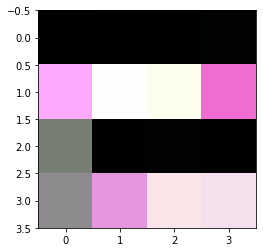

In [522]:
show_image(image)

In [523]:
image = g(torch.randn((100, 512, 1, 1), device=device))
out = d(image)

In [524]:
f = out.sigmoid() > 0.5

In [525]:
print(f)

tensor([[False],
        [False],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [ True

In [517]:
dl = get_dataloader(32)

Files already downloaded and verified


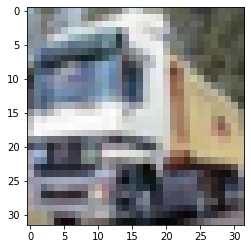

In [518]:
for i, _ in dl:
    image = i.to(device)
    show_image(i[1])
    break